# COVID-19 Diagnostic Dicease Prediction - 01

In [3]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import scipy.stats as sp
from joblib import dump, load

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import sys
sys.path.append('utils')

import dataframe_utils
import preprocess_utils
import model_utils
import metrics_utils

plt.style.use('seaborn')

### Importing and pre-visualization

In [4]:
df_covid = pd.read_excel('datasets/dataset.xlsx').drop(labels = ['Patient ID'],axis=1)
df_covid

,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,negative,0,0,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,3,positive,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5640,17,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5641,4,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5642,10,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_covid.drop([
    'Patient addmited to intensive care unit (1=yes, 0=no)',
    'Patient addmited to semi-intensive unit (1=yes, 0=no)',
    'Patient addmited to regular ward (1=yes, 0=no)'],axis = 1,inplace = True)

### Checking for missing values

In [6]:
df_counts = df_covid.count()
display(df_counts.head(56))
display(df_counts.tail(51))


Patient age quantile                                5644
SARS-Cov-2 exam result                              5644
Hematocrit                                           603
Hemoglobin                                           603
Platelets                                            602
Mean platelet volume                                 599
Red blood Cells                                      602
Lymphocytes                                          602
Mean corpuscular hemoglobin concentration (MCHC)     602
Leukocytes                                           602
Basophils                                            602
Mean corpuscular hemoglobin (MCH)                    602
Eosinophils                                          602
Mean corpuscular volume (MCV)                        602
Monocytes                                            601
Red blood cell distribution width (RDW)              602
Serum Glucose                                        208
Respiratory Syncytial Virus    

pO2 (venous blood gas analysis)              136
Fio2 (venous blood gas analysis)               1
Total CO2 (venous blood gas analysis)        136
pH (venous blood gas analysis)               136
HCO3 (venous blood gas analysis)             136
Rods #                                        97
Segmented                                     97
Promyelocytes                                 97
Metamyelocytes                                97
Myelocytes                                    97
Myeloblasts                                   97
Urine - Esterase                              60
Urine - Aspect                                70
Urine - pH                                    70
Urine - Hemoglobin                            70
Urine - Bile pigments                         70
Urine - Ketone Bodies                         57
Urine - Nitrite                                1
Urine - Density                               70
Urine - Urobilinogen                          69
Urine - Protein     

In [7]:
def drop_by_data_threshold(df,threshold,axis):

    if axis == 'row': axis = 1
    elif axis == 'col' or axis == 'column': axis = 0

    max_values = df.shape[axis]
    value_threshold = int(threshold * max_values)
    mask_values_to_keep = df.count(axis = axis) >= value_threshold
    print('threshold = ',value_threshold)
    if axis == 1: return df[mask_values_to_keep]
    elif axis == 0: return df.loc[:,mask_values_to_keep.values]

### Drop columns with less than 10% available data

In [8]:
df_covid_subset_2 = drop_by_data_threshold(df_covid,threshold = 0.1, axis = 'column')
df_covid_subset_2.count()


threshold =  564


Patient age quantile                                5644
SARS-Cov-2 exam result                              5644
Hematocrit                                           603
Hemoglobin                                           603
Platelets                                            602
Mean platelet volume                                 599
Red blood Cells                                      602
Lymphocytes                                          602
Mean corpuscular hemoglobin concentration (MCHC)     602
Leukocytes                                           602
Basophils                                            602
Mean corpuscular hemoglobin (MCH)                    602
Eosinophils                                          602
Mean corpuscular volume (MCV)                        602
Monocytes                                            601
Red blood cell distribution width (RDW)              602
Respiratory Syncytial Virus                         1354
Influenza A                    

### Drop rows with less than 90% of available features

In [98]:
df_covid_cut_2 = drop_by_data_threshold(df_covid_subset_2,threshold = 0.8, axis = 'row')
df_covid_cut_2.count()

threshold =  28


Patient age quantile                                366
SARS-Cov-2 exam result                              366
Hematocrit                                          366
Hemoglobin                                          366
Platelets                                           366
Mean platelet volume                                363
Red blood Cells                                     366
Lymphocytes                                         366
Mean corpuscular hemoglobin concentration (MCHC)    366
Leukocytes                                          366
Basophils                                           366
Mean corpuscular hemoglobin (MCH)                   366
Eosinophils                                         366
Mean corpuscular volume (MCV)                       366
Monocytes                                           365
Red blood cell distribution width (RDW)             366
Respiratory Syncytial Virus                         366
Influenza A                                     

### Drop columns with less than 80% available data

In [99]:
df_covid_final_cut = drop_by_data_threshold(df_covid_cut_2,threshold = 0.5, axis = 'column')
df_covid_final_cut.count()

threshold =  183


Patient age quantile                                366
SARS-Cov-2 exam result                              366
Hematocrit                                          366
Hemoglobin                                          366
Platelets                                           366
Mean platelet volume                                363
Red blood Cells                                     366
Lymphocytes                                         366
Mean corpuscular hemoglobin concentration (MCHC)    366
Leukocytes                                          366
Basophils                                           366
Mean corpuscular hemoglobin (MCH)                   366
Eosinophils                                         366
Mean corpuscular volume (MCV)                       366
Monocytes                                           365
Red blood cell distribution width (RDW)             366
Respiratory Syncytial Virus                         366
Influenza A                                     

### Drop NAs

In [100]:
df_covid_final_cut = df_covid_final_cut.dropna()
df_covid_final_cut.count()

Patient age quantile                                362
SARS-Cov-2 exam result                              362
Hematocrit                                          362
Hemoglobin                                          362
Platelets                                           362
Mean platelet volume                                362
Red blood Cells                                     362
Lymphocytes                                         362
Mean corpuscular hemoglobin concentration (MCHC)    362
Leukocytes                                          362
Basophils                                           362
Mean corpuscular hemoglobin (MCH)                   362
Eosinophils                                         362
Mean corpuscular volume (MCV)                       362
Monocytes                                           362
Red blood cell distribution width (RDW)             362
Respiratory Syncytial Virus                         362
Influenza A                                     

In [44]:
df_covid_final_cut

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,...,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
1,17,negative,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
8,1,negative,-1.571682,-0.774212,1.429667,-1.672222,-0.850035,-0.005738,3.331071,0.364550,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
15,9,negative,-0.747693,-0.586244,-0.429480,-0.213711,-1.361315,-1.114514,0.542882,-0.884923,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected
18,11,negative,0.991838,0.792188,0.072992,-0.550290,0.542763,0.045436,-0.452899,-0.211488,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
28,13,negative,1.014726,0.854844,-0.178244,0.796029,0.489872,-0.730707,-0.353319,-0.075131,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5585,18,positive,1.197836,1.356092,-1.911774,1.132609,0.384090,0.966573,0.841616,-0.834833,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
5602,19,negative,0.190738,0.165628,-0.102873,0.908221,0.384090,-1.583611,-0.054585,-0.328365,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
5614,19,negative,-0.289922,-0.523588,0.663397,-0.774677,0.754327,-1.532437,-1.050367,1.569499,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
5615,15,negative,0.717175,1.105468,-0.492289,-0.213711,0.613284,0.002791,1.538664,-0.550988,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected


### Visualizing categorical data values

In [45]:
mask_non_numeric = df_covid_final_cut.dtypes == object
mask_non_numeric = mask_non_numeric[mask_non_numeric]
unique_values = dataframe_utils.get_column_categories(df_covid_final_cut[mask_non_numeric.index])

Column Values:
SARS-Cov-2 exam result : ['negative' 'positive']
Respiratory Syncytial Virus : ['not_detected' 'detected']
Influenza A : ['not_detected' 'detected']
Influenza B : ['not_detected' 'detected']
Parainfluenza 1 : ['not_detected']
CoronavirusNL63 : ['not_detected' 'detected']
Rhinovirus/Enterovirus : ['detected' 'not_detected']
Coronavirus HKU1 : ['not_detected' 'detected']
Parainfluenza 3 : ['not_detected' 'detected']
Chlamydophila pneumoniae : ['not_detected']
Adenovirus : ['not_detected' 'detected']
Parainfluenza 4 : ['not_detected' 'detected']
Coronavirus229E : ['not_detected' 'detected']
CoronavirusOC43 : ['not_detected' 'detected']
Inf A H1N1 2009 : ['not_detected' 'detected']
Bordetella pertussis : ['not_detected']
Metapneumovirus : ['not_detected' 'detected']
Parainfluenza 2 : ['not_detected']


### Dropping irrelevant columns

In [46]:
irrelevant_columns = ['Bordetella pertussis','Parainfluenza 1','Parainfluenza 2','Adenovirus','Chlamydophila pneumoniae']
# irrelevant_columns = ['Parainfluenza 2']
df_covid_final_cut.drop(columns = irrelevant_columns,inplace = True)

In [47]:
categorical_columns = np.setdiff1d(mask_non_numeric.index,irrelevant_columns)
categorical_columns = np.sort(categorical_columns)
numeric_columns = np.setdiff1d(df_covid_final_cut.columns,categorical_columns)
class_label = 'SARS-Cov-2 exam result'

In [48]:
def plot_binary_class_variable_distribution(df, columns, title, class_label, classes_values = [0,1], n_columns = 4, n_rows = 10,figsize=(20, 30)):

    fig, axes = plt.subplots(n_rows,n_columns,figsize=figsize)
    fig.suptitle(title,fontsize = 20)
    
    for index,col in enumerate(columns):

        keys = df[col].value_counts().keys()
        if n_rows == 1 or n_columns == 1:
            current_ax = axes[index]
        else:
            row_index = int(index / n_columns)
            col_index = int(index - n_columns * row_index)
            current_ax = axes[row_index][col_index]

        positive = df.copy()[df[class_label] == classes_values[0]][col]
        positive = positive.value_counts()
        negative = df.copy()[df[class_label] == classes_values[1]][col]
        negative = negative.value_counts()
        ax = pd.DataFrame({str(classes_values[0]): positive, str(classes_values[1]): negative}).plot(kind='bar', stacked=True,ax = current_ax)
        ax.set_xticklabels(keys)
        ax.set_title(col)
    plt.subplots_adjust(top=0.92, bottom=0, left=0.10, right=0.95, hspace=0.40,
                    wspace=0.35)
    plt.show()


def plot_numerical_distributions(df,columns,title, n_rows = 4, n_columns = 4, figure_size = (20, 12)):
    if (n_rows * n_columns) < len(columns):
        raise Exception('Dataset Variables to be shown must be the equal or smaller than the number of rows and columns.')
    fig, axes = plt.subplots(n_rows, n_columns, figsize = figure_size)
    fig.suptitle(title,fontsize = 20)
    
    for index,col in enumerate(columns):
        
        if n_rows == 1 or n_columns == 1:
            current_ax = axes[index]
        else:
            row_index = int(index/n_columns)
            col_index = int(index - n_columns*row_index)
            current_ax = axes[row_index][col_index]

        
        ax = sns.distplot(df[col], norm_hist=False,ax = current_ax,kde = False) 
        ax.set_title(col)
        label = r'$\mu={:2.2f},\ \sigma={:2.2f},\ median={:2.2f},\ mode={:2.2f}$'.format(df[col].mean(),df[col].std(),df[col].median(),df[col].mode().values[0])
        ax.set_xlabel(label)
    plt.subplots_adjust(top=0.92,hspace = 0.45,wspace = 0.5)    
    plt.show()
    
def plot_numerical_correlation(df,title,class_label):
    scatter_matrix = sns.pairplot(df,hue=class_label,height = 4);
    scatter_matrix.fig.suptitle('Correlation Between Numerical Variables',fontsize = 20);
    plt.subplots_adjust(top=0.95)

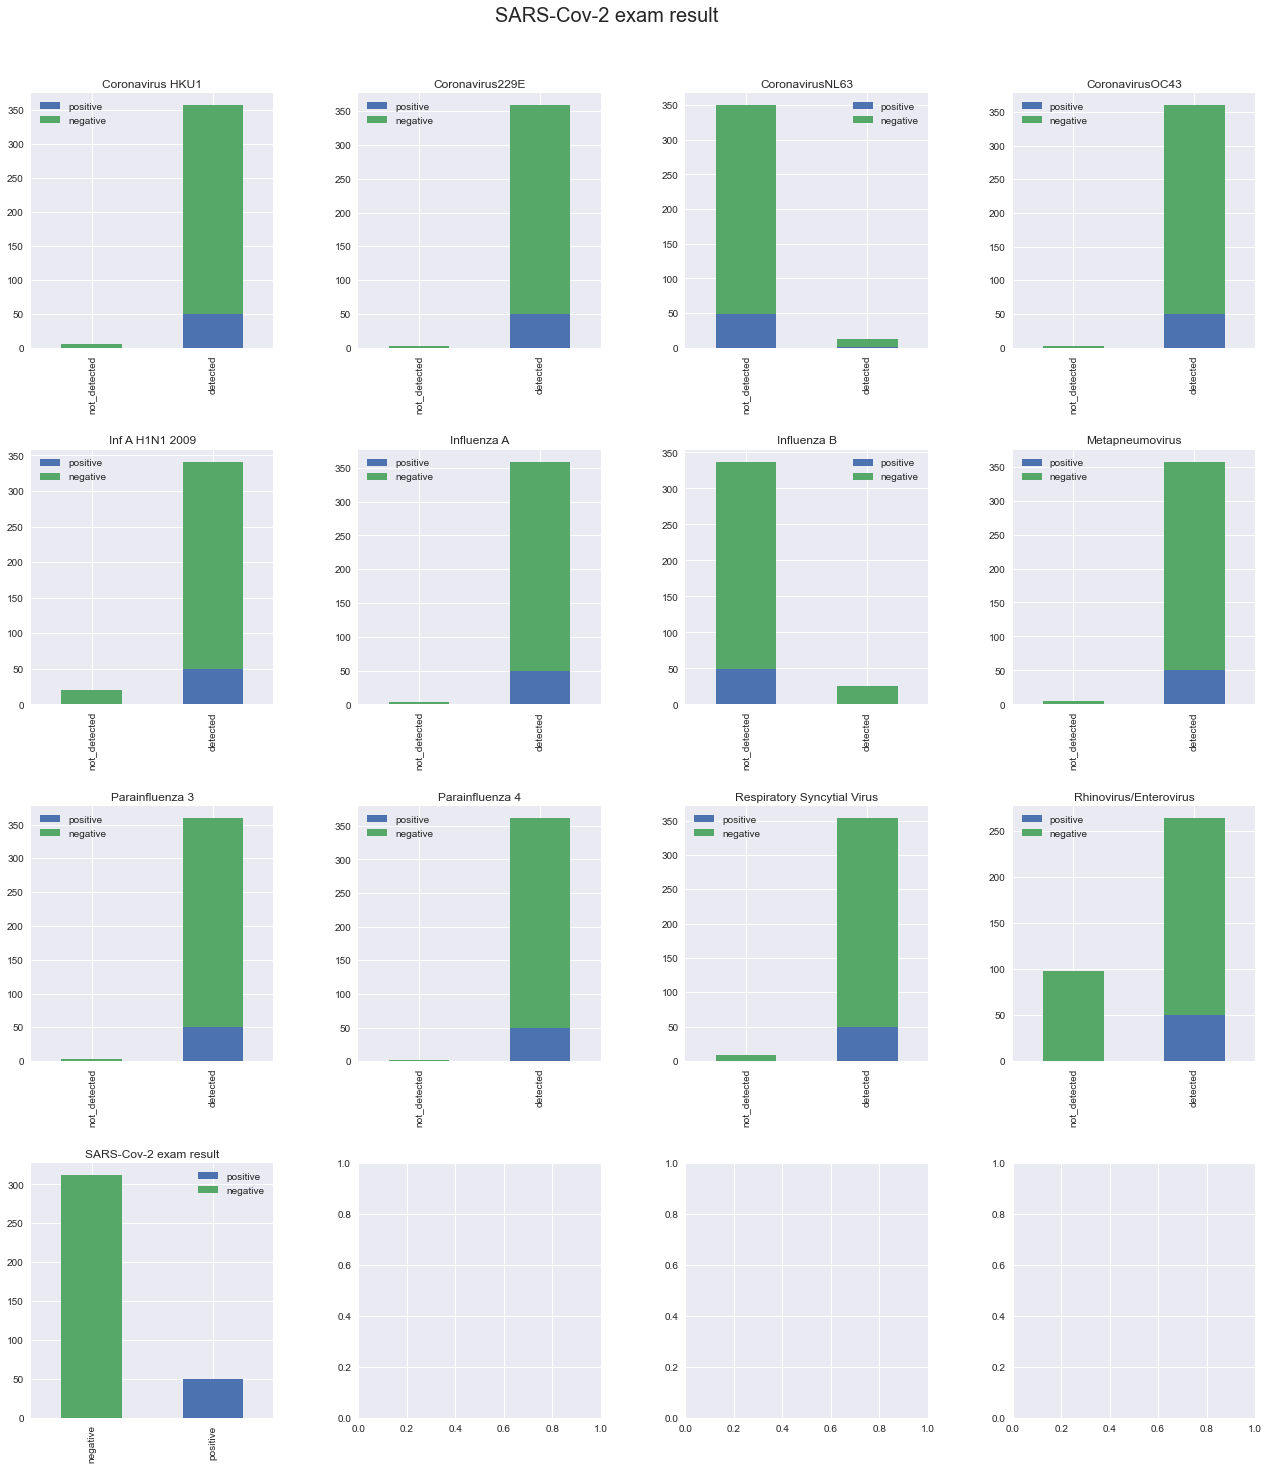

In [49]:
plot_binary_class_variable_distribution(df_covid_final_cut, columns = categorical_columns, class_label = class_label, title = class_label , classes_values = ['positive','negative'], n_columns = 4, n_rows = 4,figsize=(20, 20)) #  n_rows = 4

As we can see above, SARS-Cov-2 in an unbalanced class

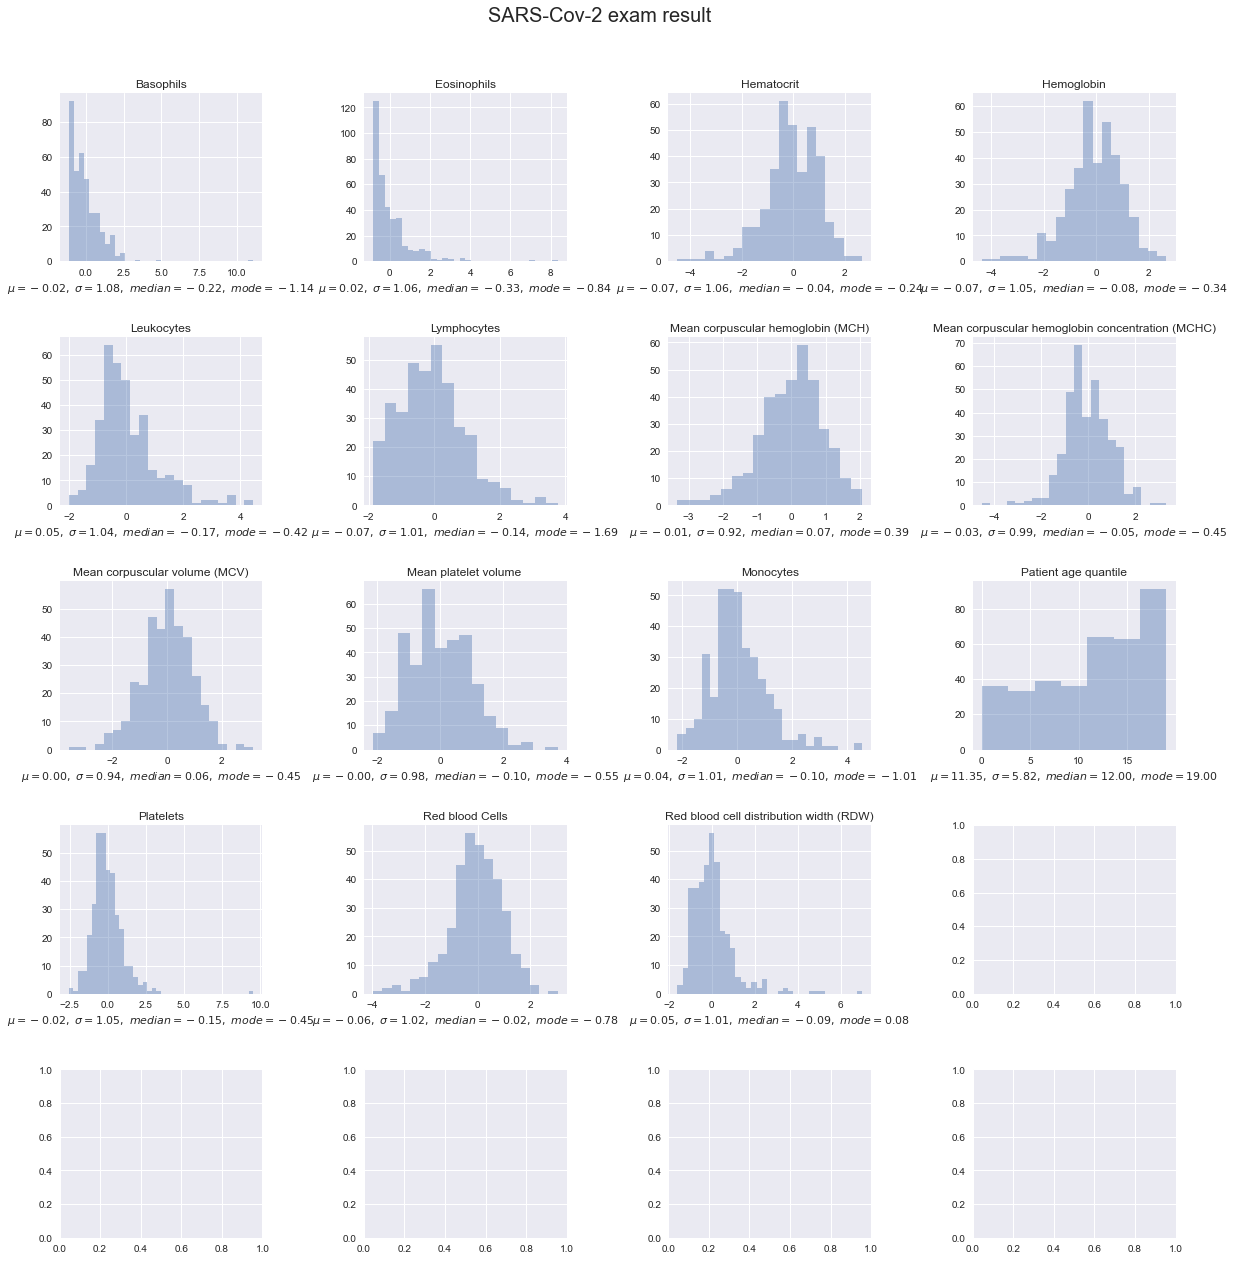

In [17]:
plot_numerical_distributions(df_covid_final_cut,columns = numeric_columns,title = class_label, n_columns = 4, n_rows = 5, figure_size = (20, 20))

In [50]:
def plot_numerical_correlation(df,title,class_label):
    scatter_matrix = sns.pairplot(df,hue=class_label,height = 4);
    scatter_matrix.fig.suptitle('Correlation Between Numerical Variables',fontsize = 20);
    plt.subplots_adjust(top=0.95)

In [51]:
# plot_numerical_correlation(df_covid_final_cut[list(numeric_columns) + [class_label]],title = class_label,class_label = class_label)

In [52]:
mask_non_numeric = df_covid_final_cut.dtypes == object
mask_non_numeric = mask_non_numeric[mask_non_numeric]
unique_values = dataframe_utils.get_column_categories(df_covid_final_cut[mask_non_numeric.index])

Column Values:
SARS-Cov-2 exam result : ['negative' 'positive']
Respiratory Syncytial Virus : ['not_detected' 'detected']
Influenza A : ['not_detected' 'detected']
Influenza B : ['not_detected' 'detected']
CoronavirusNL63 : ['not_detected' 'detected']
Rhinovirus/Enterovirus : ['detected' 'not_detected']
Coronavirus HKU1 : ['not_detected' 'detected']
Parainfluenza 3 : ['not_detected' 'detected']
Parainfluenza 4 : ['not_detected' 'detected']
Coronavirus229E : ['not_detected' 'detected']
CoronavirusOC43 : ['not_detected' 'detected']
Inf A H1N1 2009 : ['not_detected' 'detected']
Metapneumovirus : ['not_detected' 'detected']


In [54]:
for col in unique_values.keys():
    df_covid_final_cut.loc[df_covid_final_cut[col] == 'detected',col] = 1
    df_covid_final_cut.loc[df_covid_final_cut[col] == 'not_detected',col] = 0

df_covid_final_cut.loc[df_covid_final_cut[class_label] == 'positive',class_label] = 1
df_covid_final_cut.loc[df_covid_final_cut[class_label] == 'negative',class_label] = 0

In [55]:
df_covid_final_cut

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,...,Influenza B,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Metapneumovirus
1,17,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,...,0,0,1,0,0,0,0,0,0,0
8,1,0,-1.571682,-0.774212,1.429667,-1.672222,-0.850035,-0.005738,3.331071,0.364550,...,0,0,0,0,0,0,0,0,0,0
15,9,0,-0.747693,-0.586244,-0.429480,-0.213711,-1.361315,-1.114514,0.542882,-0.884923,...,0,0,0,0,0,0,0,0,1,0
18,11,0,0.991838,0.792188,0.072992,-0.550290,0.542763,0.045436,-0.452899,-0.211488,...,0,0,1,0,0,0,0,0,0,0
28,13,0,1.014726,0.854844,-0.178244,0.796029,0.489872,-0.730707,-0.353319,-0.075131,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5585,18,1,1.197836,1.356092,-1.911774,1.132609,0.384090,0.966573,0.841616,-0.834833,...,0,0,0,0,0,0,0,0,0,0
5602,19,0,0.190738,0.165628,-0.102873,0.908221,0.384090,-1.583611,-0.054585,-0.328365,...,0,0,0,0,0,0,0,0,0,0
5614,19,0,-0.289922,-0.523588,0.663397,-0.774677,0.754327,-1.532437,-1.050367,1.569499,...,0,0,0,0,0,0,0,0,0,0
5615,15,0,0.717175,1.105468,-0.492289,-0.213711,0.613284,0.002791,1.538664,-0.550988,...,0,0,0,0,0,0,0,0,0,0


In [57]:
non_float_cols = (df_covid_final_cut.dtypes == np.float).values
for col in df_covid_final_cut.columns:
    if df_covid_final_cut[col].dtypes == np.float:
        continue
    df_covid_final_cut[col] = df_covid_final_cut[col].astype(int)

In [77]:
columns_x = df_covid_final_cut.drop(columns = ['SARS-Cov-2 exam result']).columns

column_y = [class_label]

X_train, X_validation, y_train, y_validation = train_test_split(
    df_covid_final_cut[columns_x], df_covid_final_cut[column_y],  test_size=0.30, random_state=42)

In [78]:
X_train.shape

(253, 27)

In [79]:
X_validation.shape

(109, 27)

In [80]:
scaler = MinMaxScaler()
scaler.fit(df_covid_final_cut[columns_x])
dump(scaler, 'saves/minmax_scaler_no_imputation.bin', compress=True)

X_train_norm = pd.DataFrame(data=scaler.transform(X_train),columns=X_train.columns)
X_validation_norm = pd.DataFrame(data=scaler.transform(X_validation),columns=X_train.columns)

In [89]:
logistic_regression_params = {
    'C' : [0.1,1,10,100],
    'penalty' : ['l2', 'elasticnet'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
score = 'f1'
best_lr,best_lr_params,best_lr_score = model_utils.find_best_classification_model_with_cross_validation(
    LogisticRegression(random_state=0, class_weight = 'balanced'),
    logistic_regression_params,
    X_train_norm.values,
    y_train.values.ravel(),
    k_folds = 5,
    metric = 'accuracy',
    verbose = 1)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
--- Ellapsed time: 0.2629992961883545 seconds ---
Best params:  {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
Best score (accuracy) 0.8773333333333333
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished


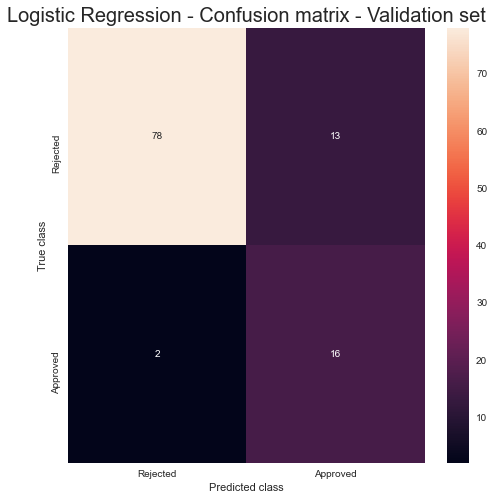

precision    recall  f1-score   support

    Rejected       0.97      0.86      0.91        91
    Approved       0.55      0.89      0.68        18

    accuracy                           0.86       109
   macro avg       0.76      0.87      0.80       109
weighted avg       0.91      0.86      0.87       109

No Skill: ROC AUC=0.500
Logistic Regression : ROC AUC=0.900


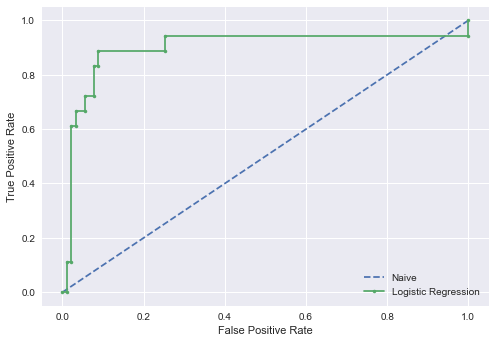

['saves/logistic_regression_no_imputation.bin']

In [90]:
df_result = model_utils.predict(best_lr,X_validation_norm,y_validation);
metrics_utils.evalute_model_performance(best_lr, 'Logistic Regression',X_validation_norm,y_validation,df_result)
dump(best_lr, 'saves/logistic_regression_no_imputation.bin', compress=True)

In [94]:
ridge_regression_params = {
    'alpha' : [1,10,100],
    'solver' : ['auto', 'svd', 'lsqr']
}

best_ridge,best_ridge_params,best_ridge_score = model_utils.find_best_classification_model_with_cross_validation(
    RidgeClassifier(random_state=0, class_weight = 'balanced'),
    ridge_regression_params,
    X_train_norm.values,
    y_train.values.ravel(),
    k_folds = 5,
    metric = 'accuracy',
    verbose = 1)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
--- Ellapsed time: 0.0890352725982666 seconds ---
Best params:  {'alpha': 1, 'solver': 'auto'}
Best score (accuracy) 0.8221176470588235
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.0s finished


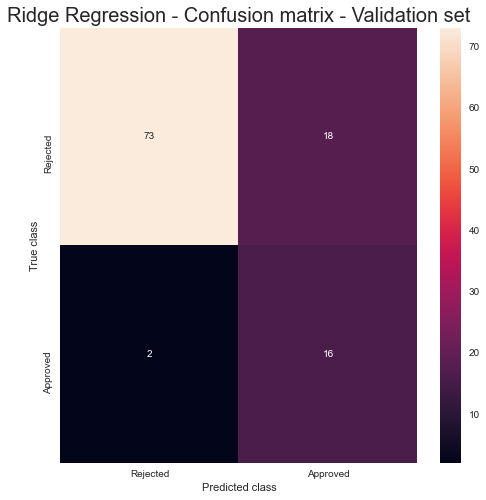

precision    recall  f1-score   support

    Rejected       0.97      0.80      0.88        91
    Approved       0.47      0.89      0.62        18

    accuracy                           0.82       109
   macro avg       0.72      0.85      0.75       109
weighted avg       0.89      0.82      0.84       109

Could not print ROC AUC curve.


['saves/ridge_regression_no_imputation.bin']

In [95]:
df_result = model_utils.predict(best_ridge,X_validation_norm,y_validation);
metrics_utils.evalute_model_performance(best_ridge, 'Ridge Regression',X_validation_norm,y_validation,df_result)
dump(best_ridge, 'saves/ridge_regression_no_imputation.bin', compress=True)

### Visualizing weights of the Logistic Regression

In [30]:
def create_feature_importance_by_feature_weight(features,model):
    
    '''
        Create a Dataframe based on the Weights given to each feature by regression models, with the following columns:
            Weights: Weights of the models
            abs_Weights: Absolute value of the weights
            feature_importance: Normalized weights (all values of this column add up to one)
            abs_feature_importance: Absolute value of the feature importance

    '''

    df_weights = pd.DataFrame(index = features,columns = ['Weights'])
    df_weights['Weights'] = model.coef_.ravel()
    df_weights['abs_Weights'] = np.abs(df_weights['Weights'])
    total_weights = df_weights['abs_Weights'].values.ravel().sum()
    df_weights['feature_importance'] = df_weights['Weights'].values / total_weights
    df_weights['abs_feature_importance'] = df_weights['abs_Weights'].values / total_weights
    df_weights.sort_values(by=['abs_feature_importance'],ascending = False,inplace = True)
    return df_weights

def show_feature_importance_by_feature_weight(df_weights,model_title, color = None, absolute_values = False, feature_importance = False,figsize=(8,8)):

    '''
        Show a feature importance bar plot by model feature weights.

        Parameters:

        df_weights: Dataframe created by the function create_feature_importance_by_feature_weight(). 
        Contains the weights of the features and also their feature importances (values that add up to one)

        model_title: Title of the model to plot

        color: Tuple to give different colors to positive and negative weights. Example color = ('red','green')

        absolute_values: Flag to analyse just absolute values of weights

        feature_importance: Flag to select feature importance instead of weights 

    '''

    column = 'Weights'
    if absolute_values:
        column = 'abs_Weights'
    if feature_importance:
        column = column.replace('Weights','feature_importance')

    df_weights = df_weights.sort_values(by=[column],ascending = True,inplace = False)
    fig,ax = plt.subplots(1,figsize=figsize)
    colors = (0.2,0.4,0.8)
    if color is not None:
        color_mask = df_weights['feature_importance'] > 0
        colors = [color[0] if c else color[1] for c in color_mask]
        legend_elements = [
            Patch(facecolor = color[1], edgecolor='k', label='Negative Contribution'),
            Patch(facecolor = color[0], edgecolor='k', label='Positive Contribution')]
    
    ax.tick_params(axis = 'both',labelsize = 'large')
    df_weights[column].plot(kind = 'barh', grid = True, color = colors,edgecolor='k', alpha = 0.6,ax = ax)
    fig.suptitle(f'Feature Importance by Feature Weight - {model_title}',x = 0.3,fontsize = 20)

    if color:
        ax.legend(handles=legend_elements, bbox_to_anchor=(1, -0.05), borderaxespad=0.,fancybox=True, shadow=True,ncol = 2)

    if feature_importance:
        plt.figtext(0.91, 0.03, '*All absolute values add up to one', horizontalalignment='right')
    if absolute_values:
        plt.figtext(0.91, 0.01, '*All values are absolute', horizontalalignment='right')

    plt.subplots_adjust(top=0.93, bottom=0, left=0.10, right=0.95, hspace=0.40, wspace=0.35)
    plt.show()
    

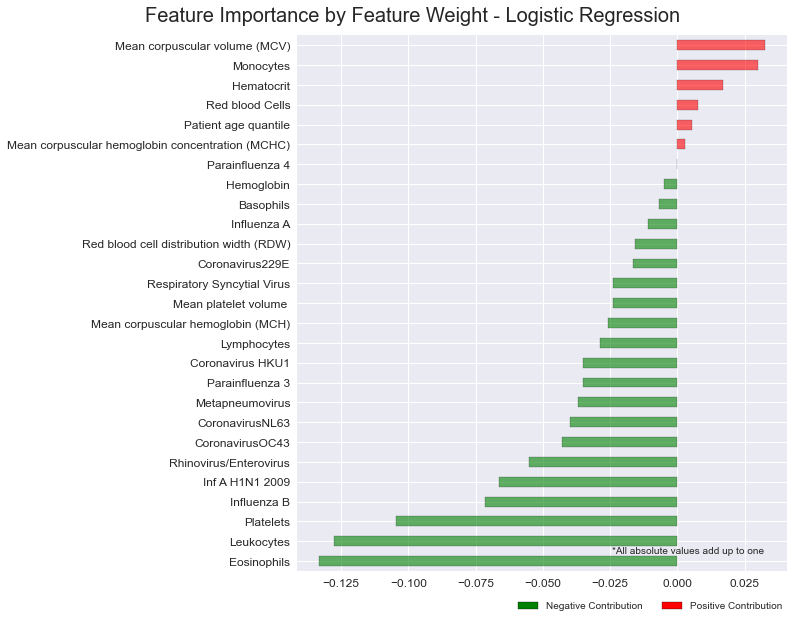

In [31]:
df_weights = create_feature_importance_by_feature_weight(features = columns_x,model = best_lr)
show_feature_importance_by_feature_weight(df_weights,'Logistic Regression', color = ('r','g'), absolute_values = False,feature_importance = True)

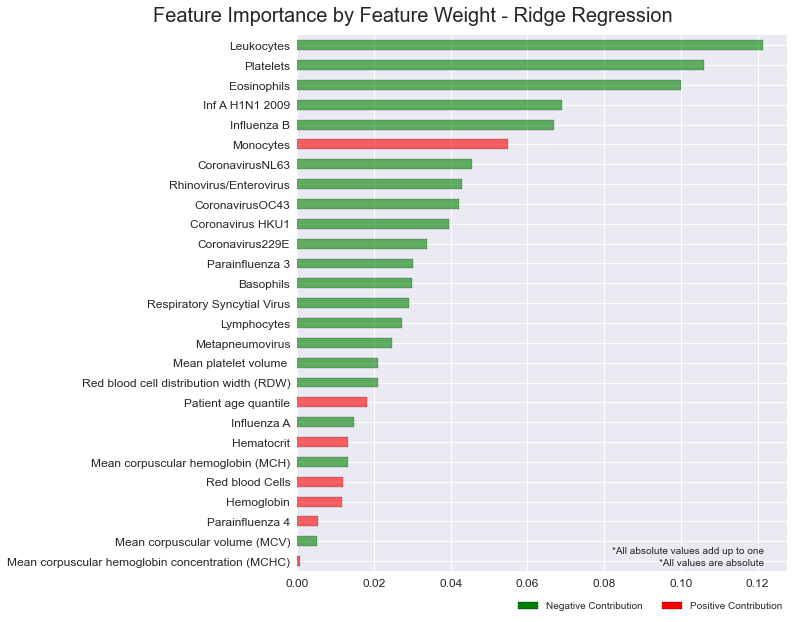

In [32]:
df_weights = create_feature_importance_by_feature_weight(features = columns_x,model = best_ridge)
show_feature_importance_by_feature_weight(df_weights,'Ridge Regression', color = ('r','g'), absolute_values = True,feature_importance = True)

In [33]:
# maybe try to eliminate least important variables and train model to predict again.

In [34]:
import numpy as np
from sklearn.svm import SVC


svm_params = {
    'C' : [1,10,100,1000],
    'gamma' : ['auto', 'scale'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree' : [2,3,4,5],
    'coef0' : [0,1,2,3],


}

best_svm,best_svm_params,best_svm_score = model_utils.find_best_classification_model_with_cross_validation(
    SVC(class_weight = 'balanced'),
    svm_params,
    X_train_norm.values,
    y_train.values.ravel(),
    k_folds = 5,
    metric = score)

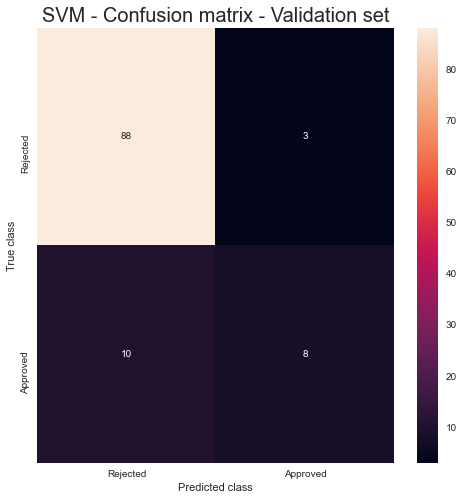

precision    recall  f1-score   support

    Rejected       0.90      0.97      0.93        91
    Approved       0.73      0.44      0.55        18

    accuracy                           0.88       109
   macro avg       0.81      0.71      0.74       109
weighted avg       0.87      0.88      0.87       109

Could not print ROC AUC curve.


['saves/svm_no_imputation.bin']

In [35]:
df_result = model_utils.predict(best_svm,X_validation_norm,y_validation);
metrics_utils.evalute_model_performance(best_svm, 'SVM',X_validation_norm,y_validation,df_result)
dump(best_ridge, 'saves/svm_no_imputation.bin', compress=True)